### CALL CENTER OPERATIONS ANALYTICS
Author Diana Kung'u

Questions:
1. Number/proposition of Calls per Reason
2. Call Center activity peak analysis <br> 
     - Distribution of Calls by day of week/month and hour of day
3. Abandonment rate <br>

     - Estimate number of potential customers lost.

4. Wait Duration
5. Incoming calls
6. Agent Performance


In [83]:
# Load libraries
import pandas as pd
import time

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='white')

In [27]:

#Read data
#.............................................................................................
chunks = pd.read_csv(r'.\Data\call center.csv', parse_dates=['Call Date Time'], chunksize= 5000)
call_df = pd.concat(chunks, ignore_index= True)

In [150]:
df = call_df.copy()
df.head(3)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s)
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6


In [151]:
#Data Processing 
#Split call date and time fields
Call_Date, Call_Time= zip(*[(d.date(), d.time()) for d in df['Call Date Time']])
df['Call Date'], df['Call Time'] =[Call_Date, Call_Time]

#Format Date and time columns to datetime objects
df['Call Date'] = pd.to_datetime(df['Call Date'], format='%Y-%m-%d')
df['Call Time'] = df['Call Time'].apply(lambda x: x.strftime('%H:%M'))
df.head(2)

,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21


In [152]:
# Parse the Year, Month Day, and hour of each call
df['Year'] = df['Call Date'].dt.year
df['Month'] = df['Call Date'].dt.month
df['Day of Week'] = [d.strftime("%A") for d in df['Call Date']]
df['Hour'] =  df['Call Date Time'].dt.hour
df['Day'] = df['Call Date'].dt.day
df.head(3)


,Abandon Flag,Agent,Agent Selection Group,Call #,Call Date Time,Call Reason,Customer,First Contact Resolution Flag,Talk Time (s),Wait Time (s),Call Date,Call Time,Year,Month,Day of Week,Hour,Day
0,N,Anabel Grebert,Other,3800023,2021-11-30 09:46:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,143,5,2021-11-30,09:46,2021,11,Tuesday,9,30
1,N,Anabel Grebert,Other,3796097,2021-11-29 08:21:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,38,6,2021-11-29,08:21,2021,11,Monday,8,29
2,N,Anabel Grebert,Other,3772171,2021-11-18 10:20:00,Billing Questions,"Anderson, Schoen and Pfannerstill",N,54,6,2021-11-18,10:20,2021,11,Thursday,10,18


In [153]:
#Duplicated Call #
df.drop_duplicates(keep='first', inplace= True)

In [165]:
#df[df.duplicated(['Call #'])]

In [166]:
df.drop_duplicates('Call #', keep='first', inplace= True)

#### Call Reasons
1. Frequency of call by reasons
2. Distribution

1. Frequency of Calls by reason

In [167]:
# Unique call reasons
reasons  = df['Call Reason'].unique().tolist()
#Frequency of each reason
df_reasons = df.groupby(['Call Reason']).agg(No_Calls =('Call #', 'count')).reset_index()
df_reasons['Proportion'] =df_reasons['No_Calls']*100/df_reasons['No_Calls'].sum()
df_reasons['Proportion %'] = df_reasons['Proportion'].map('{:,.1f}%'.format)
df_reasons

,Call Reason,No_Calls,Proportion,Proportion %
0,Billing Questions,53107,22.061548,22.1%
1,Internet Outage,69534,28.885602,28.9%
2,New Customer,5580,2.318027,2.3%
3,Other,889,0.369306,0.4%
4,Product/Service Problems,20950,8.702985,8.7%
5,Technical Issues,90662,37.662532,37.7%


<AxesSubplot:title={'center':'Proportion of Calls per Reason'}, xlabel='Call Reason', ylabel='Proportion'>

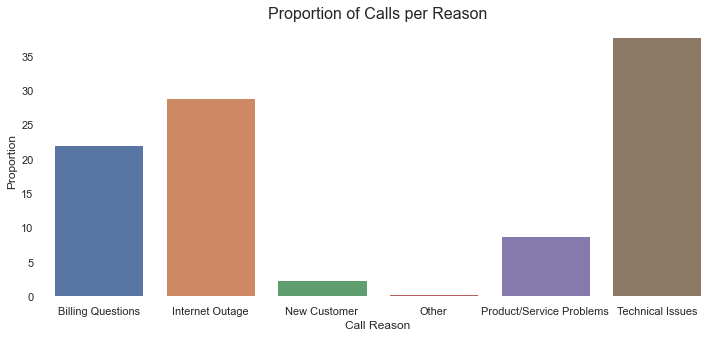

In [168]:
plt.figure(figsize=(12,5))
plt.title('Proportion of Calls per Reason', fontsize = 16)

sns.despine(bottom = True, left = True)
sns.barplot(x = 'Call Reason', y = 'Proportion', data = df_reasons)


Technical Issues, Internet Outages and Billing Questions account for the largest number
of calls.

2. Distribution

   I. Day of month/week

Number of calls per reason by day/day of week are evenly distributed.

In [169]:
df_day_distribution = df.groupby(['Call Reason', 'Day of Week']).agg(No_Calls =('Call #', 'count')).reset_index()
df_day_distribution.head(2)

,Call Reason,Day of Week,No_Calls
0,Billing Questions,Friday,8815
1,Billing Questions,Monday,10712


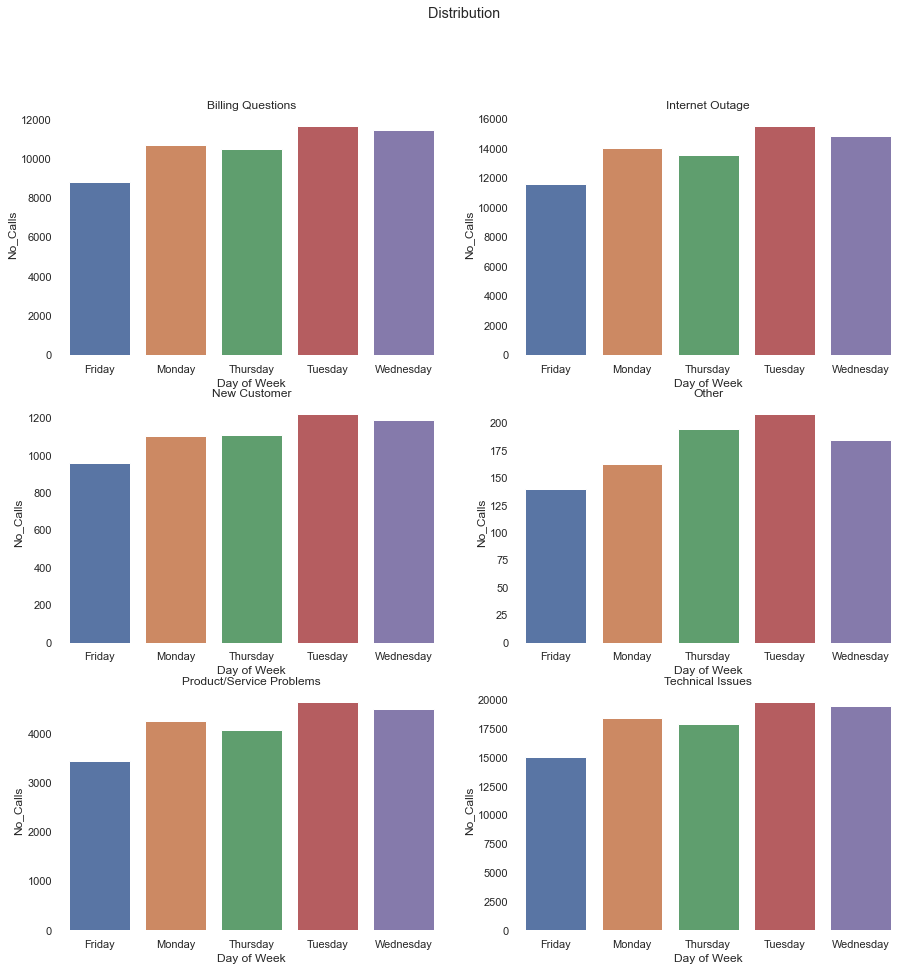

In [170]:
figure, axis = plt.subplots(3, 2,figsize=(15, 15), facecolor='w', edgecolor='k')

a = 3 #rows
b = 2 # columns
c = 1 # subplot iterator

for i in df_day_distribution['Call Reason'].unique():
    plt.subplot(a, b, c)
    plt.title(f'{i}')
    plt.xlabel(i)
    plt.suptitle('Distribution ')
    plt.ylabel('')
    #cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.barplot(x = 'Day of Week', y = 'No_Calls', data = df_day_distribution[df_day_distribution['Call Reason'] == i])
    sns.despine(bottom = True, left = True)
    c = c + 1
                

In [178]:
#Distribution by hour and day of week
#Heatmap 
daily_dist = df.groupby(['Day of Week','Hour']).agg(No_Calls =('Call #', 'count')).reset_index()


In [172]:
#Total Incoming call in 2021
len(df[df['Year'] ==2021])

126011

In [180]:
#No. of Agents
df[df['Year'] ==2021]['Agent'].nunique()
df['Customer'].nunique()

12